In [1]:
from ultralytics import YOLO
import ultralytics
from pathlib import Path
import pandas as pd
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from PIL import Image

DATASET_BASE_NAME = "Weed-crop RGB dataset" 
TARGET_CROP_NAME = "Sugar beet"    

# --- MODEL AND TRAINING CONSTANTS ---
MODEL_NAME = "yolo11n.pt"  # Base model weights to be used
IMG_SIZE = 640             # Image size for training/testing
BATCH_SIZE = 4             # Batch size
EPOCHS = 100               # Number of epochs
PATIENCE = 20              # Early stopping patience
DEVICE_ID = 0              # GPU device ID (e.g., 0)
RUNS_BASE_DIR = Path("runs") # Folder nadrzędny dla wszystkich wyników YOLO

# --- DATASET CONFIGURATION (Dynamic Paths) ---

DATASET_ROOT = Path(DATASET_BASE_NAME)
AUG_DIR_NAME = f"{TARGET_CROP_NAME}_augmented"
DATA_CONFIG_AUG = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_augmented.yaml" 
DATA_CONFIG_ORIGINAL = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_original.yaml" 
CLASSES_FILE = DATASET_ROOT / AUG_DIR_NAME / "classes.txt"
JSON_FILE_PATH = DATASET_ROOT / AUG_DIR_NAME / f"{TARGET_CROP_NAME.lower()}_stats.json"

# --- RUN DIRECTORIES (Separating Experiments) ---
# Używamy zgeneralizowanych nazw folderów dla obu eksperymentów w notatniku

ORIGINAL_PROJECT_NAME = f"{TARGET_CROP_NAME}_original"
AUGMENTED_PROJECT_NAME = f"{TARGET_CROP_NAME}_augmented"

ORIGINAL_OUTPUT_DIR = RUNS_BASE_DIR / ORIGINAL_PROJECT_NAME
os.makedirs(ORIGINAL_OUTPUT_DIR, exist_ok=True)

AUGMENTED_OUTPUT_DIR = RUNS_BASE_DIR / AUGMENTED_PROJECT_NAME
os.makedirs(AUGMENTED_OUTPUT_DIR, exist_ok=True)

# --- DERIVED PATHS FOR LATER USE ---
def get_final_paths(base_path, experiment_name):
    run_folder = base_path / experiment_name 
    return {
        'weights': run_folder / 'weights' / 'best.pt',
        'plot_pr': run_folder / 'evaluation' / 'BoxPR_curve.png',
        'plot_res': run_folder / 'results.png'
    }

ORIGINAL_PATHS = get_final_paths(RUNS_BASE_DIR, ORIGINAL_PROJECT_NAME)
AUGMENTED_PATHS = get_final_paths(RUNS_BASE_DIR, AUGMENTED_PROJECT_NAME)

EDGE_THRESHOLD = 0.03  # How close to the edge should be the crop
WEED_DISTANCE_THRESHOLD = 0.2 # How far away the weed should be from teh crop so that it isn't its neighbor
MIN_BOX_AREA_PERCENTAGE = 0.25 # 

# Ablation study - what do we expect to happen?

The core challenge in applying object detection to this agricultural dataset is the severe class imbalance between the majority crop and the minority weed classes. To address this, we implemented a context-aware undersampling strategy focused on mitigating noise caused by low-context crop instances at image borders. This targeted preprocessing successfully reduced the majority class instance count by 40.0%. We expect model to achieve better 

In [2]:
def load_class_names_from_file(file_path):
    with open(file_path, 'r') as f:
        class_names = {str(i): line.strip() for i, line in enumerate(f)}
    return class_names

CLASS_NAMES = load_class_names_from_file(CLASSES_FILE)
with open(JSON_FILE_PATH, 'r') as f:
    stats_data = json.load(f)

df_stats = pd.DataFrame.from_dict(stats_data, orient='index').T
df_stats = df_stats.fillna(0).astype(int) 
df_stats['deleted instances'] = df_stats['train'] - df_stats['train_augmented']
new_index_names = [CLASS_NAMES.get(idx, idx) for idx in df_stats.index.astype(str)]
df_stats.index = new_index_names
columns_to_display = ['train', 'train_augmented', 'deleted instances']
print("--- Detailed Class Distribution and Augmentation Impact ---")
display(df_stats[columns_to_display])

--- Detailed Class Distribution and Augmentation Impact ---


,train,train_augmented,deleted instances
Sugar beet,850,570,280
Kochia,98,98,0
Ragweed,134,134,0
Horseweed,31,31,0
Waterhemp,58,58,0
Soybean,24,20,4
Redroot Pigweed,31,31,0
Flax,15,15,0
Canola,13,13,0
Lentil,8,8,0


# Model training on Original Dataset

In [11]:
original_model = YOLO(MODEL_NAME)

baseline_train_results = original_model.train(
    data=str(DATA_CONFIG_ORIGINAL),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=ORIGINAL_PROJECT_NAME,  
    project=RUNS_BASE_DIR,   
    device=DEVICE_ID,
    patience=PATIENCE
)

print(f"Original dataset model saved to: {ORIGINAL_PATHS['weights'].parent}")

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Sugar beet_augmented/sugar beet_original.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, 

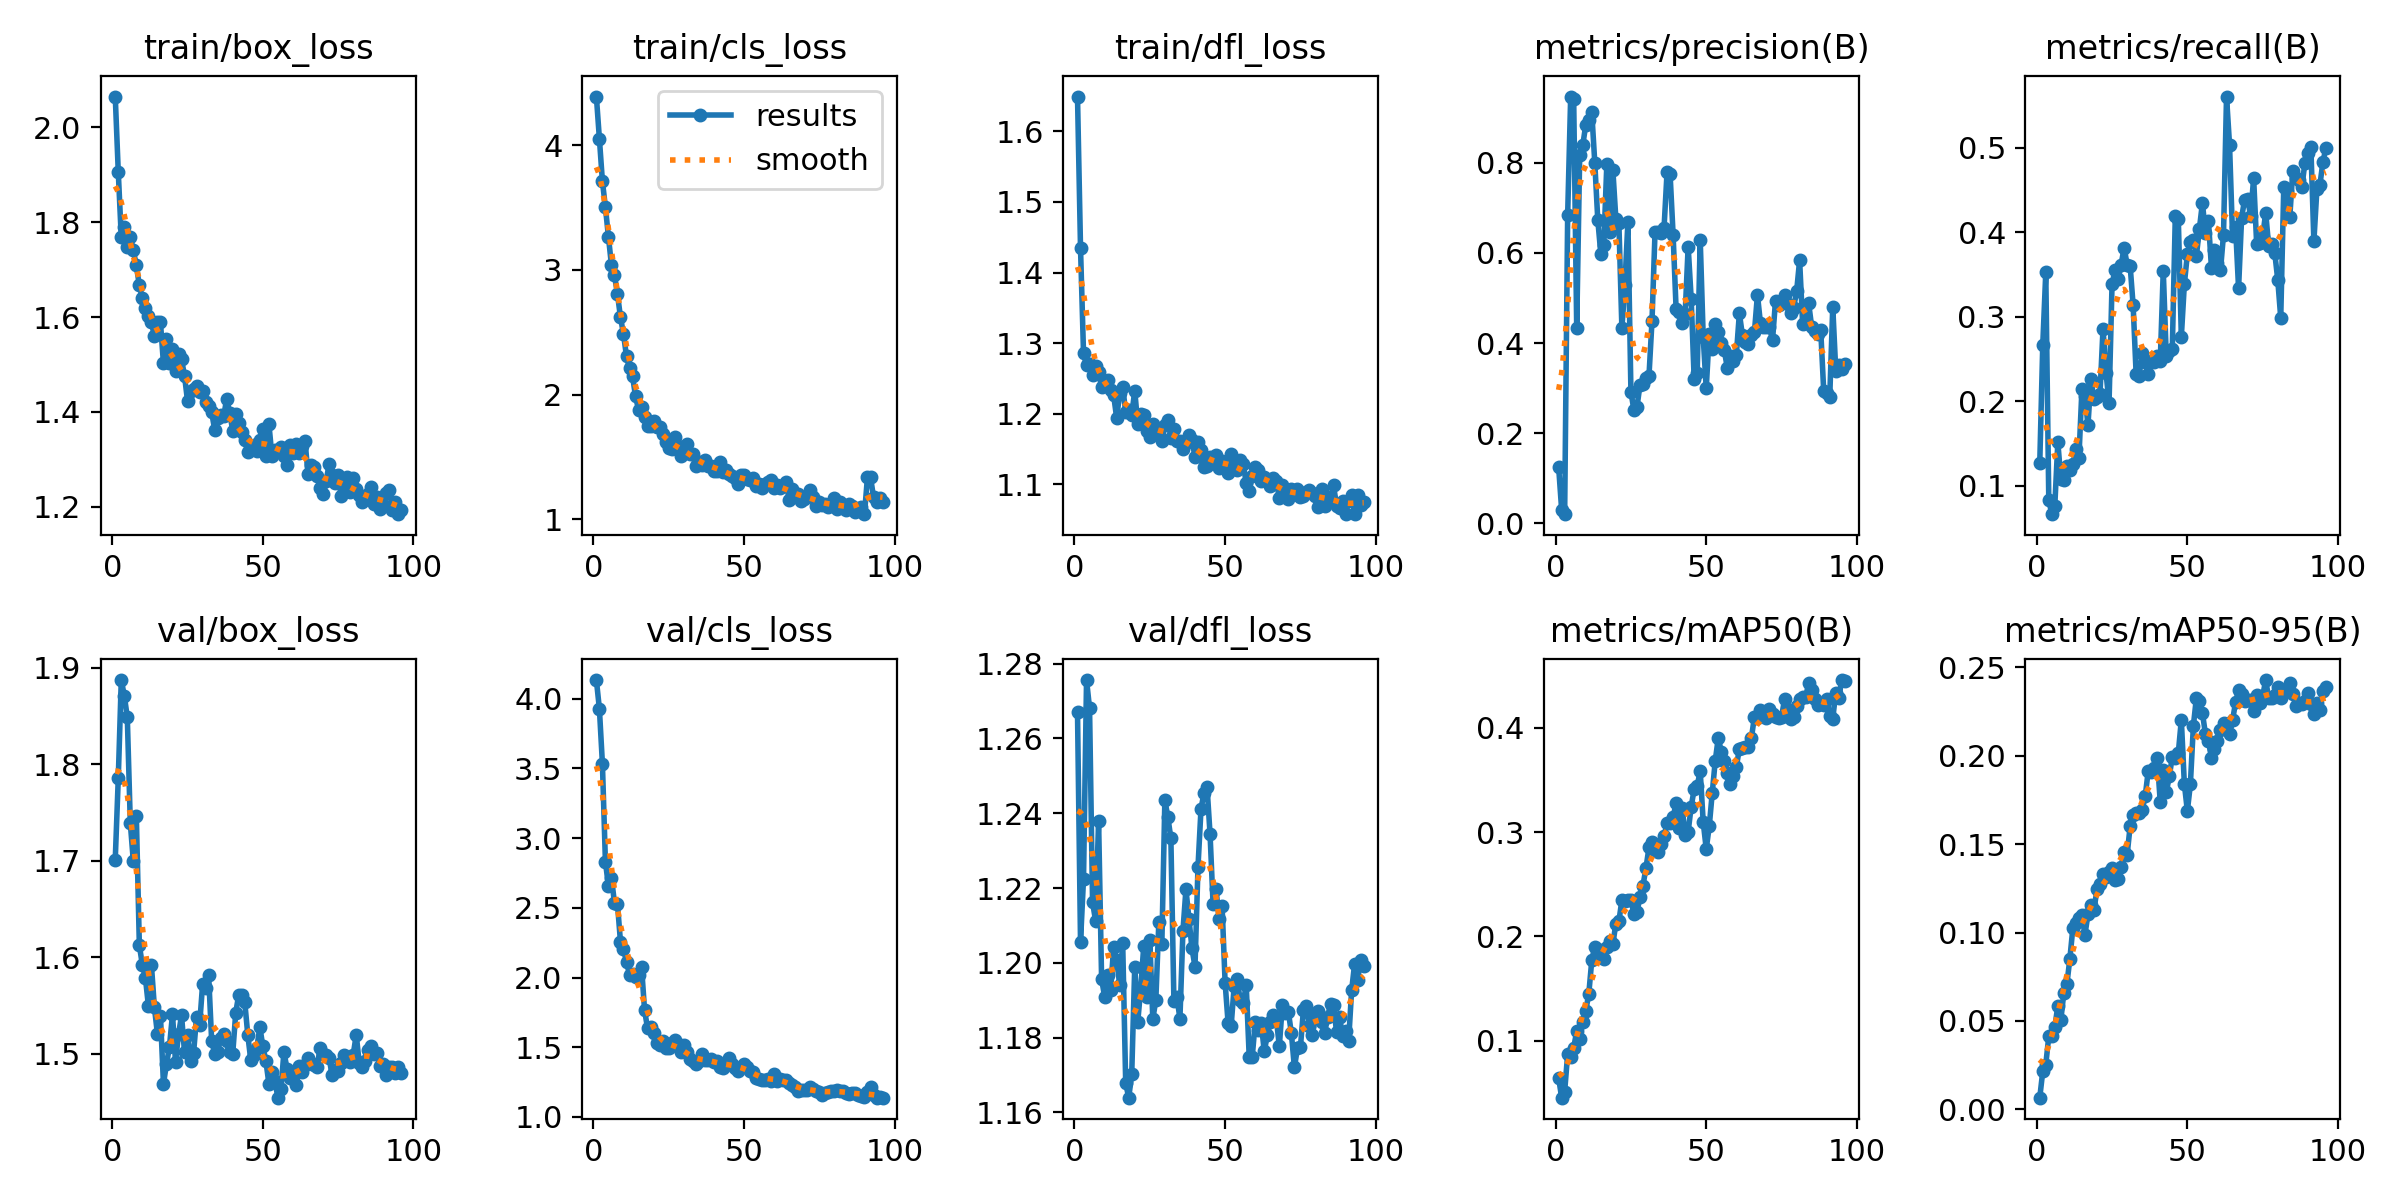

In [12]:

original_plot_path = ORIGINAL_PATHS['plot_res']
img_original = Image.open(original_plot_path)
display(img_original)


In [13]:
BEST_WEIGHTS_PATH = ORIGINAL_PATHS['weights'] 

final_trained_model = YOLO(str(BEST_WEIGHTS_PATH))

export_name = f"{TARGET_CROP_NAME.lower()}_yolo11n_original.pt"
export_path = RUNS_BASE_DIR / export_name
final_trained_model.save(export_path)

print(f"Model saved to: {export_path}")

Model saved to: runs/sugar beet_yolo11n_original.pt


## Model training on Augmented Dataset

In [4]:
augmented_model = YOLO(MODEL_NAME)

baseline_train_results = augmented_model.train(
    data=str(DATA_CONFIG_AUG),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=AUGMENTED_PROJECT_NAME,  
    project=RUNS_BASE_DIR,   
    device=DEVICE_ID,
    patience=PATIENCE
)

print(f"Original dataset model saved to: {AUGMENTED_PATHS['weights'].parent}")

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Sugar beet_augmented/sugar beet_augmented.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0,

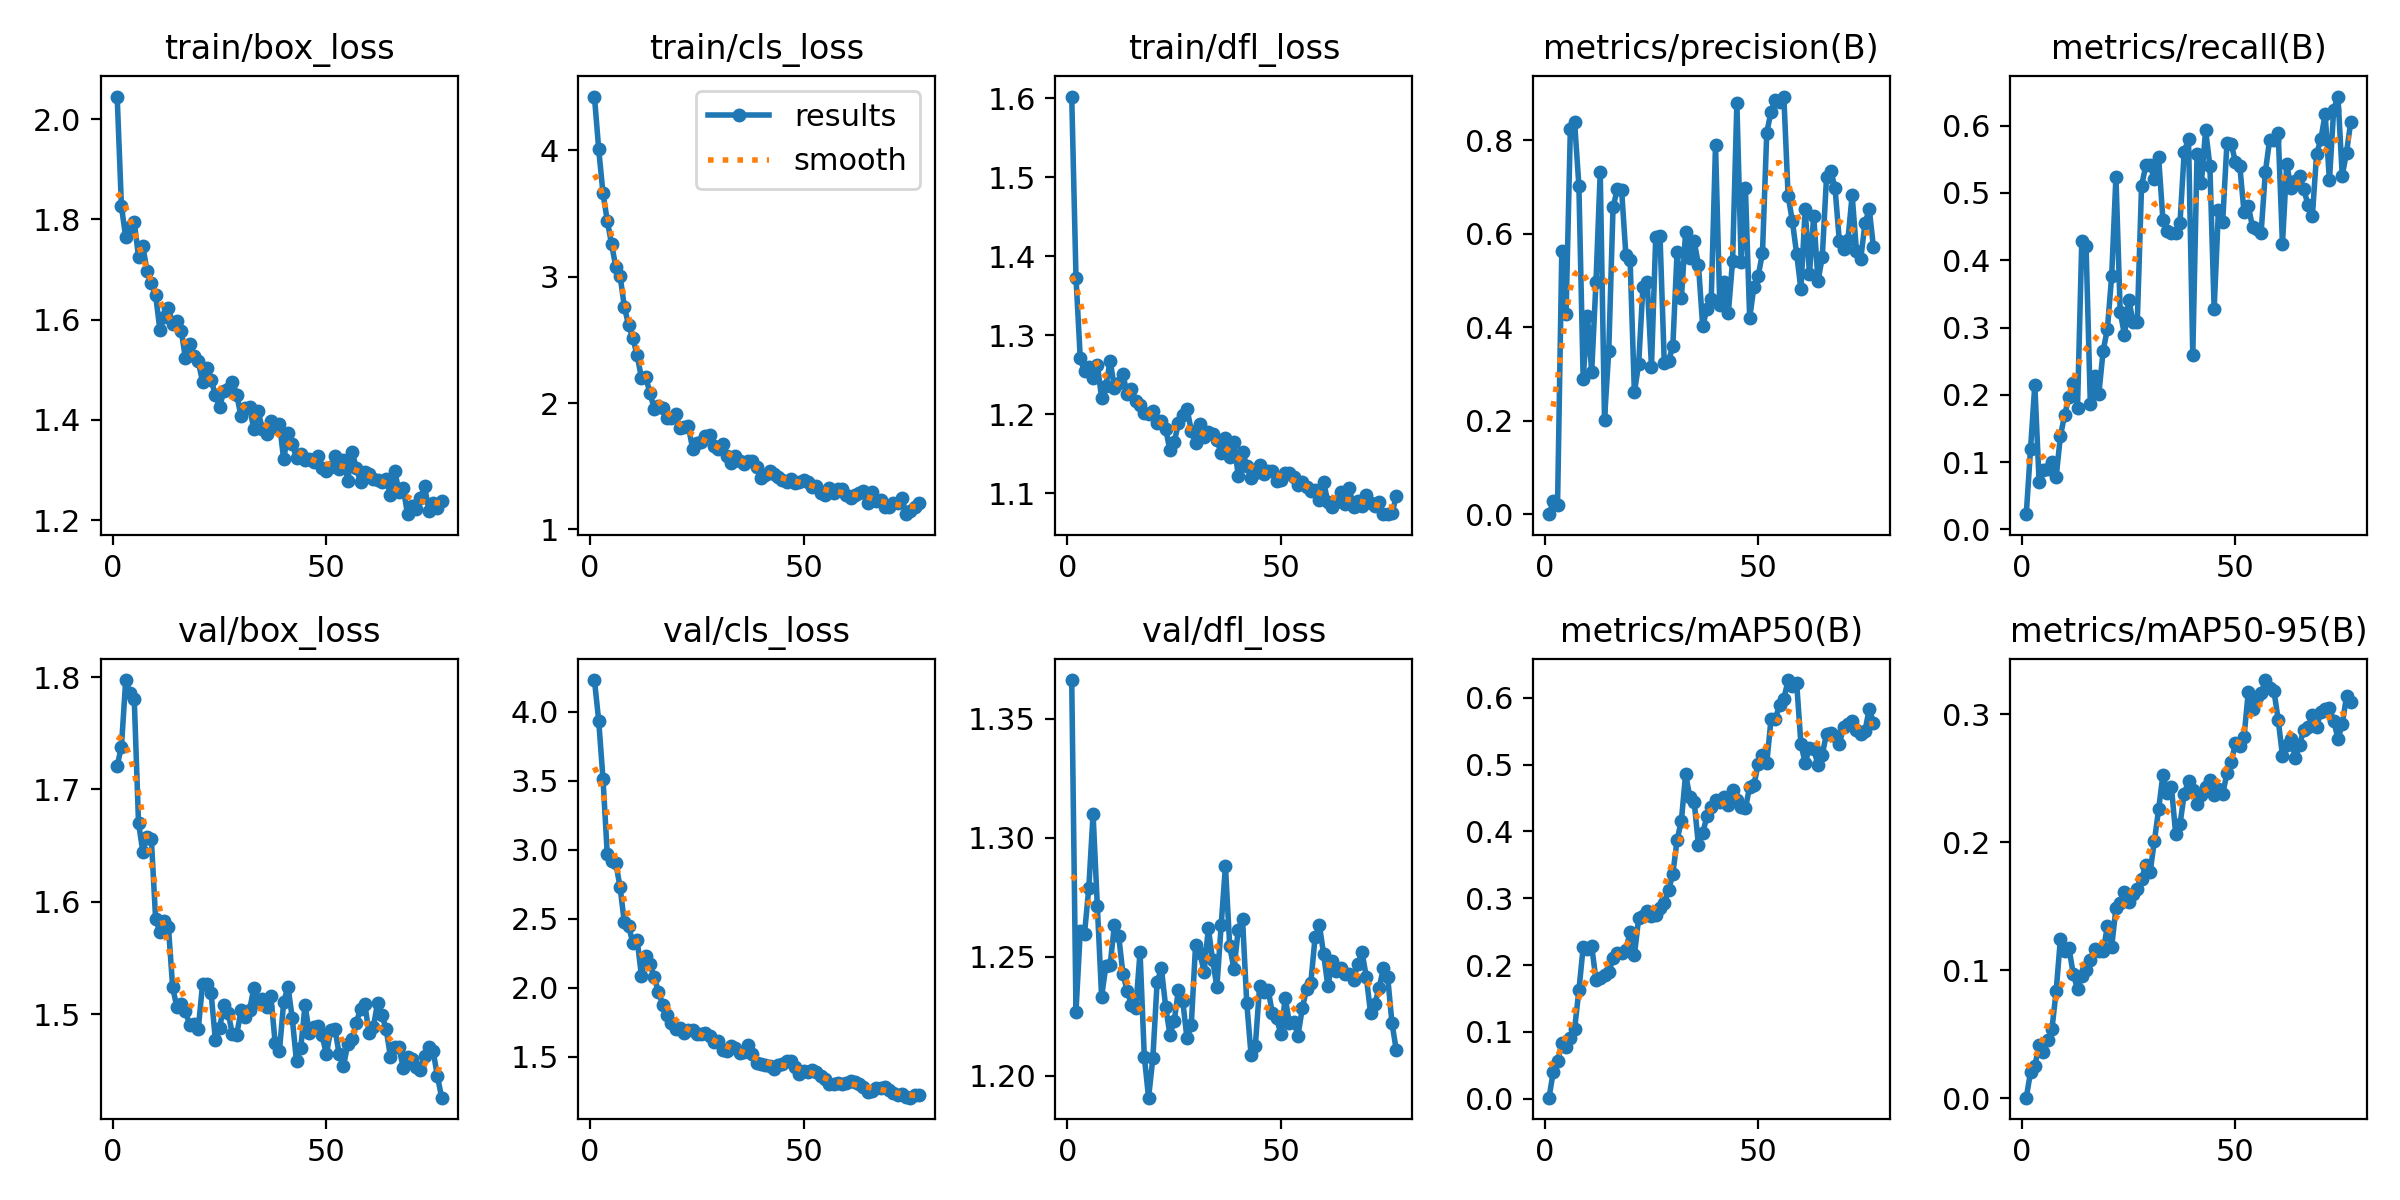

In [12]:

augmented_plot_path = AUGMENTED_PATHS['plot_res']
img_augmented = Image.open(augmented_plot_path)
display(img_augmented)

In [5]:
BEST_WEIGHTS_PATH = AUGMENTED_PATHS['weights'] 

final_trained_model = YOLO(str(BEST_WEIGHTS_PATH))

export_name = f"{TARGET_CROP_NAME.lower()}_yolo11n_augmented.pt"
export_path = RUNS_BASE_DIR / export_name
final_trained_model.save(export_path)

print(f"Model saved to: {export_path}")

Model saved to: runs/sugar beet_yolo11n_augmented.pt


# Evaluation on test dataset

### Model trained on original dataset evaluation

In [6]:

BEST_MODEL_PATH = ORIGINAL_PATHS['weights'] 
print(f"Loading best model from: {BEST_MODEL_PATH}")
final_model = YOLO(str(BEST_MODEL_PATH))

print("\n--- Final Evaluation on TEST Dataset ---")
original_metrics = final_model.val(
    data=str(DATA_CONFIG_ORIGINAL), 
    split='test',      
    imgsz=IMG_SIZE,
    project=str(ORIGINAL_OUTPUT_DIR),
    name = "evaluation"
)

print(original_metrics)
print("\n--- Results on Test Set ---")
print(f"Mean Average Precision (mAP50-95): {original_metrics.box.map:.4f}")
print(f"mAP50 (Test): {original_metrics.box.map50:.4f}")

if hasattr(original_metrics.box.mr, 'mean'):
    print(f"Recall (Test): {original_metrics.box.mr.mean():.4f}")
else:
    print(f"Recall (Test): {original_metrics.box.mr:.4f}")

Loading best model from: runs/Sugar beet_original/weights/best.pt

--- Final Evaluation on TEST Dataset ---
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1217.1±158.3 MB/s, size: 4000.5 KB)
val: Scanning /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Sugar beet_augmented/test... 14 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 14/14 1.6Kit/s 0.0s
val: New cache created: /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Sugar beet_augmented/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.5it/s 2.0s
                   all         14        138      0.591      0.344      0.426      0.223
                Canola          1          1          1          0

### Model trained on augmented dataset evaluation

In [7]:

BEST_MODEL_PATH = AUGMENTED_PATHS['weights'] 
print(f"Loading best model from: {BEST_MODEL_PATH}")
final_model = YOLO(str(BEST_MODEL_PATH))

print("\n--- Final Evaluation on TEST Dataset ---")
augmented_metrics = final_model.val(
    data=str(DATA_CONFIG_AUG), 
    split='test',      
    imgsz=IMG_SIZE,
    project=str(AUGMENTED_OUTPUT_DIR),
    name = "evaluation"
)

print(augmented_metrics)
print("\n--- Results on Test Set ---")
print(f"Mean Average Precision (mAP50-95): {augmented_metrics.box.map:.4f}")
print(f"mAP50 (Test): {augmented_metrics.box.map50:.4f}")

if hasattr(augmented_metrics.box.mr, 'mean'):
    print(f"Recall (Test): {augmented_metrics.box.mr.mean():.4f}")
else:
    print(f"Recall (Test): {augmented_metrics.box.mr:.4f}")

Loading best model from: runs/Sugar beet_augmented/weights/best.pt

--- Final Evaluation on TEST Dataset ---
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4253.4±2536.5 MB/s, size: 5254.7 KB)
val: Scanning /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Sugar beet_augmented/test.cache... 14 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 14/14 26.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.5it/s 1.9s
                   all         14        138      0.655      0.366      0.382       0.22
                Canola          1          1          1          0          0          0
                  Flax          1          5       0.59       0.58      0.521      0.297
             Hor

### Report

In [8]:
def extract_class_metrics(metrics_obj, label):

    evaluated_iids = metrics_obj.box.ap_class_index.tolist()
    
    ap50_arr = metrics_obj.box.ap50.flatten().tolist()
    ap_arr = metrics_obj.box.ap.flatten().tolist()

    full_class_names = metrics_obj.names
    
    nc_evaluated = len(ap50_arr) 
    
    data_list = []
    
    for i in range(nc_evaluated): 
        
        class_id = evaluated_iids[i]
        class_name = full_class_names[class_id]
        
        data_list.append({
            'Class': class_name, 
            f'mAP@0.5 ({label})': ap50_arr[i],
            f'mAP@0.5:0.95 ({label})': ap_arr[i]
        })

    df = pd.DataFrame(data_list)
    
    df = df[(df[f'mAP@0.5 ({label})'] > 0) | (df[f'mAP@0.5:0.95 ({label})'] > 0)]
    df.set_index('Class', inplace=True)
    return df

def extract_general_metrics(metrics_obj, label):
    
    mp = metrics_obj.box.mp
    mr = metrics_obj.box.mr
    
    precision = mp.mean() if hasattr(mp, 'mean') else mp
    recall = mr.mean() if hasattr(mr, 'mean') else mr
    
    data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)'],
        label: [metrics_obj.box.map50, metrics_obj.box.map, precision, recall]
    }
    df = pd.DataFrame(data).set_index('Metric')
    return df

In [9]:
def extract_general_metrics(metrics_obj, label):
    
    mp = metrics_obj.box.mp
    mr = metrics_obj.box.mr
    
    total_time_ms = metrics_obj.speed['preprocess'] + metrics_obj.speed['inference'] + metrics_obj.speed['postprocess']
    fps = 1000 / total_time_ms 
    
    precision = mp.mean() if hasattr(mp, 'mean') else mp
    recall = mr.mean() if hasattr(mr, 'mean') else mr

    #ap_small = metrics_obj.box.ap[7] if len(metrics_obj.box.ap) > 7 else 0 

    
    data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)', 
                   #'AP_Small (APs)', 
                   'Inference FPS'],
        label: [
            metrics_obj.box.map50, 
            metrics_obj.box.map, 
            precision, 
            recall,
            #ap_small, 
            fps
        ]
    }
    df = pd.DataFrame(data).set_index('Metric')
    return df

In [10]:

df_augmented_general = extract_general_metrics(augmented_metrics, 'Augmented')
df_original_general = extract_general_metrics(original_metrics, 'Original')

df_general_comparison = df_augmented_general.join(df_original_general, how='outer')
df_general_comparison['Difference'] = df_general_comparison['Original'] - df_general_comparison['Augmented']

print("\n--- Model Comparison: Overall Metrics  ---")
display(df_general_comparison.round(4))

df_augmented_class = extract_class_metrics(augmented_metrics, 'Augmented')
df_original_class = extract_class_metrics(original_metrics, 'Original')

df_class_comparison = df_augmented_class.join(df_original_class, how='outer').fillna(0)
df_class_comparison['Diff mAP@0.5'] = df_class_comparison['mAP@0.5 (Augmented)'] - df_class_comparison['mAP@0.5 (Original)'] 
df_class_comparison['Diff mAP@0.5:0.95'] = df_class_comparison['mAP@0.5:0.95 (Augmented)'] - df_class_comparison['mAP@0.5:0.95 (Original)']

print("\n--- Model Comparison: Class-Wise Details ---")
display(df_class_comparison.round(4))


--- Model Comparison: Overall Metrics  ---


,Augmented,Original,Difference
Metric,,,
Inference FPS,235.4415,79.2551,-156.1864
Precision (P),0.6545,0.5908,-0.0637
Recall (R),0.3657,0.3439,-0.0219
mAP@0.5,0.3821,0.4257,0.0437
mAP@0.5:0.95,0.2201,0.2234,0.0033



--- Model Comparison: Class-Wise Details ---


,mAP@0.5 (Augmented),mAP@0.5:0.95 (Augmented),mAP@0.5 (Original),mAP@0.5:0.95 (Original),Diff mAP@0.5,Diff mAP@0.5:0.95
Class,,,,,,
Canola,0.0000,0.0000,0.0332,0.0232,-0.0332,-0.0232
Flax,0.5214,0.2967,0.5321,0.2616,-0.0107,0.0352
Horseweed,0.4450,0.1855,0.5848,0.2706,-0.1398,-0.0850
Kochia,0.5896,0.3008,0.5783,0.2611,0.0113,0.0397
Ragweed,0.5047,0.2900,0.5494,0.3266,-0.0447,-0.0366
Redroot Pigweed,0.3533,0.2628,0.2317,0.1478,0.1216,0.1150
Soybean,0.0276,0.0055,0.3317,0.0995,-0.3040,-0.0940
Sugar beet,0.7770,0.4699,0.7762,0.4746,0.0007,-0.0047
Waterhemp,0.2200,0.1693,0.2141,0.1458,0.0059,0.0235


**mAP@0.5** - Mean Average Precision at IoU ≥50%. Measures if the model successfully identifies the object with reasonable overlap.

**mAP@0.5:0.95** - Mean of Average Precisions across IoU thresholds from 50% to 95%. It's a highly sensitive metric that measures how precisely the model predicts the exact location and shape of the bounding box.

A high mAP@0.5 but low mAP@0.5:0.95 means the model detects objects well but struggles with precise localization (it can't pinpoint the exact borders of the weed).

**Metric interpretation:**
* Weeds (Horseweed): Decreased by 12.86% (−0.1286). The intended targets (minority classes) were negatively affected by the augmentation.
* Crops (Blackbean, Canola, Flax): Decreased significantly (up to −0.1311 for Flax). The aggressive cutting removed valuable contextual information needed to distinguish healthy crops.
* Corn (Majority Target): Increased by +4.19% (+0.0419). This is the only improvement, indicating that the augmentation succeeded in making the remaining 'Corn' easier to identify, but only at the expense of all other classes.

The strategy was too destructive. While it successfully reduced the 'Corn' count (our hypothesis), it eliminated crucial visual context required by the model for accurate detection of neighboring plants.

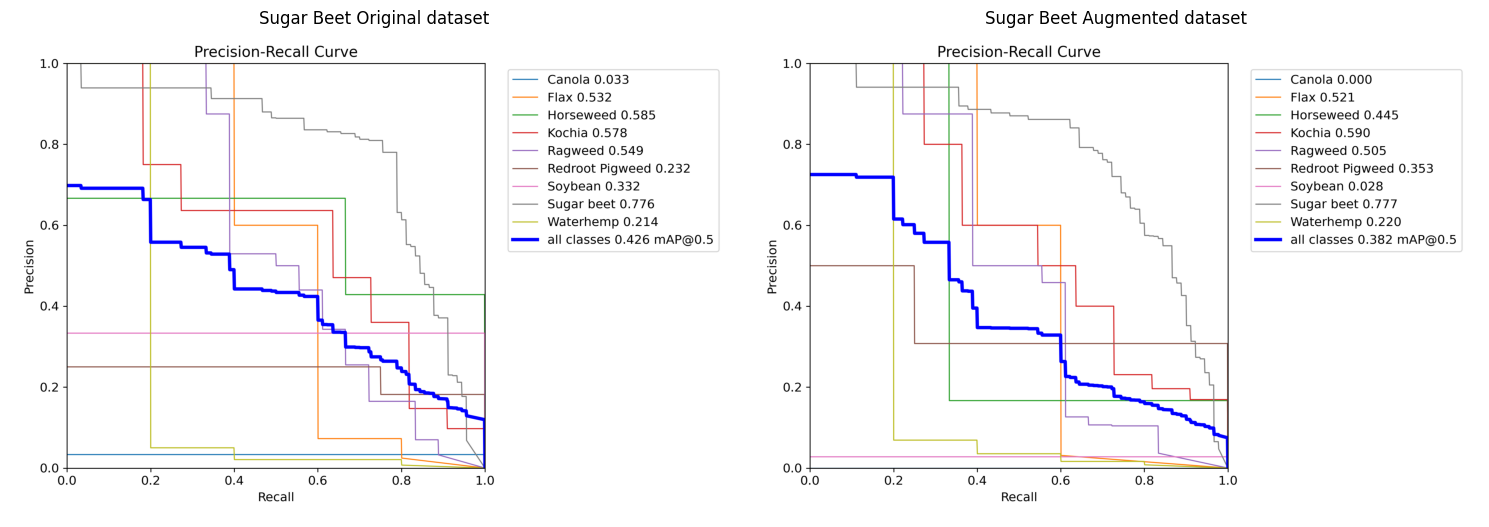

In [11]:
PATH_ORIGINAL = ORIGINAL_PATHS['plot_pr']
PATH_AUGMENTED = AUGMENTED_PATHS['plot_pr']

TITLE_ORIGINAL = ORIGINAL_PROJECT_NAME.replace('_', ' ').title()
TITLE_AUGMENTED = AUGMENTED_PROJECT_NAME.replace('_', ' ').title()

%matplotlib inline

try:
    img_original = Image.open(PATH_ORIGINAL)
    img_augmented = Image.open(PATH_AUGMENTED)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    axes[0].imshow(img_original)
    axes[0].set_title(f'{TITLE_ORIGINAL} dataset')
    axes[0].axis('off') 

    axes[1].imshow(img_augmented)
    axes[1].set_title(f'{TITLE_AUGMENTED} dataset')
    axes[1].axis('off') 

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: One or both PR curve plots were not found.")
    print("Please ensure both the Baseline and Augmented models have been trained and have saved 'BoxPR_curve.png' in the correct folders.")
except Exception as e:
    print(f"An unexpected error occurred during image display: {e}")